# Mutation Classification: Model Comparison

This notebook compares several classifiers for predicting mutation status using different preprocessed datasets. All random processes use a fixed random seed for reproducibility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

RANDOM_SEED = 42

## Data Loading and Preprocessing

Define a function to load and preprocess each dataset. This ensures consistent handling of columns, missing values, splitting, and scaling.

In [2]:
def load_and_preprocess(path, index_col=None, drop_cols=None, target_col='Mutated'):
    """
    Loads a CSV file and applies standard preprocessing:
    - Drops specified columns if present.
    - Drops 'Unnamed: 0' if present.
    - Drops 'ModelID' if present.
    - Splits into train/test and scales features.
    Returns: (X_train_scaled, X_test_scaled, y_train, y_test, feature_names)
    """
    df = pd.read_csv(path, index_col=index_col)
    if drop_cols:
        df = df.drop(columns=drop_cols, errors='ignore')
    df = df.drop(columns=['Unnamed: 0', 'ModelID'], errors='ignore')
    # Separate target before selecting numeric features
    target = df[target_col]
    features = df.drop(columns=[target_col, 'VariantType'], errors='ignore')
    features = features.select_dtypes(include=[np.number])
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=RANDOM_SEED
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, features.columns

## Prepare Datasets

Load all datasets and store them in a list for easy iteration. Each entry contains scaled train/test splits and feature names.

In [3]:
dataset_paths = [
    ('../data/processed/ccle/ccle_quantile_filtered.csv', None),
    ('../data/processed/ccle/ccle_tp53_filtered.csv', None),
    ('../data/processed/ccle/ccle_variance_filtered.csv', None),
    ('../data/processed/ccle/merged_data.csv', 1)
]
drop_cols = ['VariantLabel']

datasets = []
for path, idx_col in dataset_paths:
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess(path, index_col=idx_col, drop_cols=drop_cols)
    datasets.append((X_train, X_test, y_train, y_test, feature_names))

## Model Training and Evaluation Function

This function trains and evaluates a given model on each dataset, displaying accuracy, F1 score, confusion matrix, and feature importance.

In [4]:
def train_and_evaluate_on_datasets(datasets, model_name, dataset_names=None):
    model_map = {
        'logistic': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
        'svm': SVC(kernel='rbf', probability=True, random_state=RANDOM_SEED),
        'random_forest': RandomForestClassifier(random_state=RANDOM_SEED),
        'xgboost': XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED),
    }

    if model_name not in model_map:
        raise ValueError(f"Unsupported model: {model_name}")

    model = model_map[model_name]
    num_datasets = len(datasets)
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(num_datasets)]
    fig, axes = plt.subplots(nrows=num_datasets, ncols=2, figsize=(12, 5 * num_datasets))
    if num_datasets == 1:
        axes = [axes]

    for idx, (X_train, X_test, y_train, y_test, feature_names) in enumerate(datasets):
        dataset_title = dataset_names[idx] if idx < len(dataset_names) else f"Dataset {idx+1}"
        # Train the model
        if model_name in ['catboost', 'xgboost']:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_proba = None
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_proba = None

        acc = accuracy_score(y_test, y_pred)
        f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
        auc = None
        if y_proba is not None and len(np.unique(y_test)) == 2:
            auc = roc_auc_score(y_test, y_proba)
            print(f"{dataset_title} - Accuracy: {acc:.4f} - F1 Score: {f1:.4f} - AUC: {auc:.4f} - Model: {model_name}")
        else:
            print(f"{dataset_title} - Accuracy: {acc:.4f} - F1 Score: {f1:.4f} - AUC: {auc:.4f} - Model: {model_name}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx][0])
        axes[idx][0].set_title(f'{dataset_title} - Confusion Matrix')
        axes[idx][0].set_xlabel('Predicted')
        axes[idx][0].set_ylabel('True')

        # Feature importance
        if model_name in ['random_forest', 'catboost', 'xgboost']:
            importances = model.feature_importances_
        elif model_name in ['svm', 'logistic']:
            if hasattr(model, 'coef_'):
                importances = np.abs(model.coef_).flatten()
            else:
                axes[idx][1].axis('off')
                continue
        else:
            axes[idx][1].axis('off')
            continue

        indices = np.argsort(importances)[::-1][:10]
        top_features = feature_names[indices]
        sns.barplot(x=importances[indices], y=top_features, ax=axes[idx][1])
        axes[idx][1].set_title(f'{dataset_title} - Feature Importance')

    plt.tight_layout()
    plt.show()

# Random baseline

In [5]:
from sklearn.dummy import DummyClassifier
def random_baseline(X_train, X_test, y_train, y_test):
    dummy = DummyClassifier(strategy="uniform", random_state=RANDOM_SEED)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
    print(f"Random Baseline - Accuracy: {acc:.4f} - F1 Score: {f1:.4f}")

def majority_baseline(X_train, X_test, y_train, y_test):
    dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
    print(f"Majority Baseline - Accuracy: {acc:.4f} - F1 Score: {f1:.4f}")

# Evaluate random and majority baselines
print("Evaluating Random Baseline:")
random_baseline(X_train, X_test, y_train, y_test)
print("Evaluating Majority Baseline:")
majority_baseline(X_train, X_test, y_train, y_test)

Evaluating Random Baseline:
Random Baseline - Accuracy: 0.4513 - F1 Score: 0.4679
Evaluating Majority Baseline:
Majority Baseline - Accuracy: 0.6713 - F1 Score: 0.5393


## Logistic Regression (One-vs-Rest)

Quantile Filtered - Accuracy: 0.8496 - F1 Score: 0.8508 - AUC: 0.8986 - Model: logistic
TP53 Filtered - Accuracy: 0.8357 - F1 Score: 0.8339 - AUC: 0.8812 - Model: logistic
Variance Filtered - Accuracy: 0.8384 - F1 Score: 0.8405 - AUC: 0.9003 - Model: logistic
Not Filtered - Accuracy: 0.8412 - F1 Score: 0.8429 - AUC: 0.8980 - Model: logistic


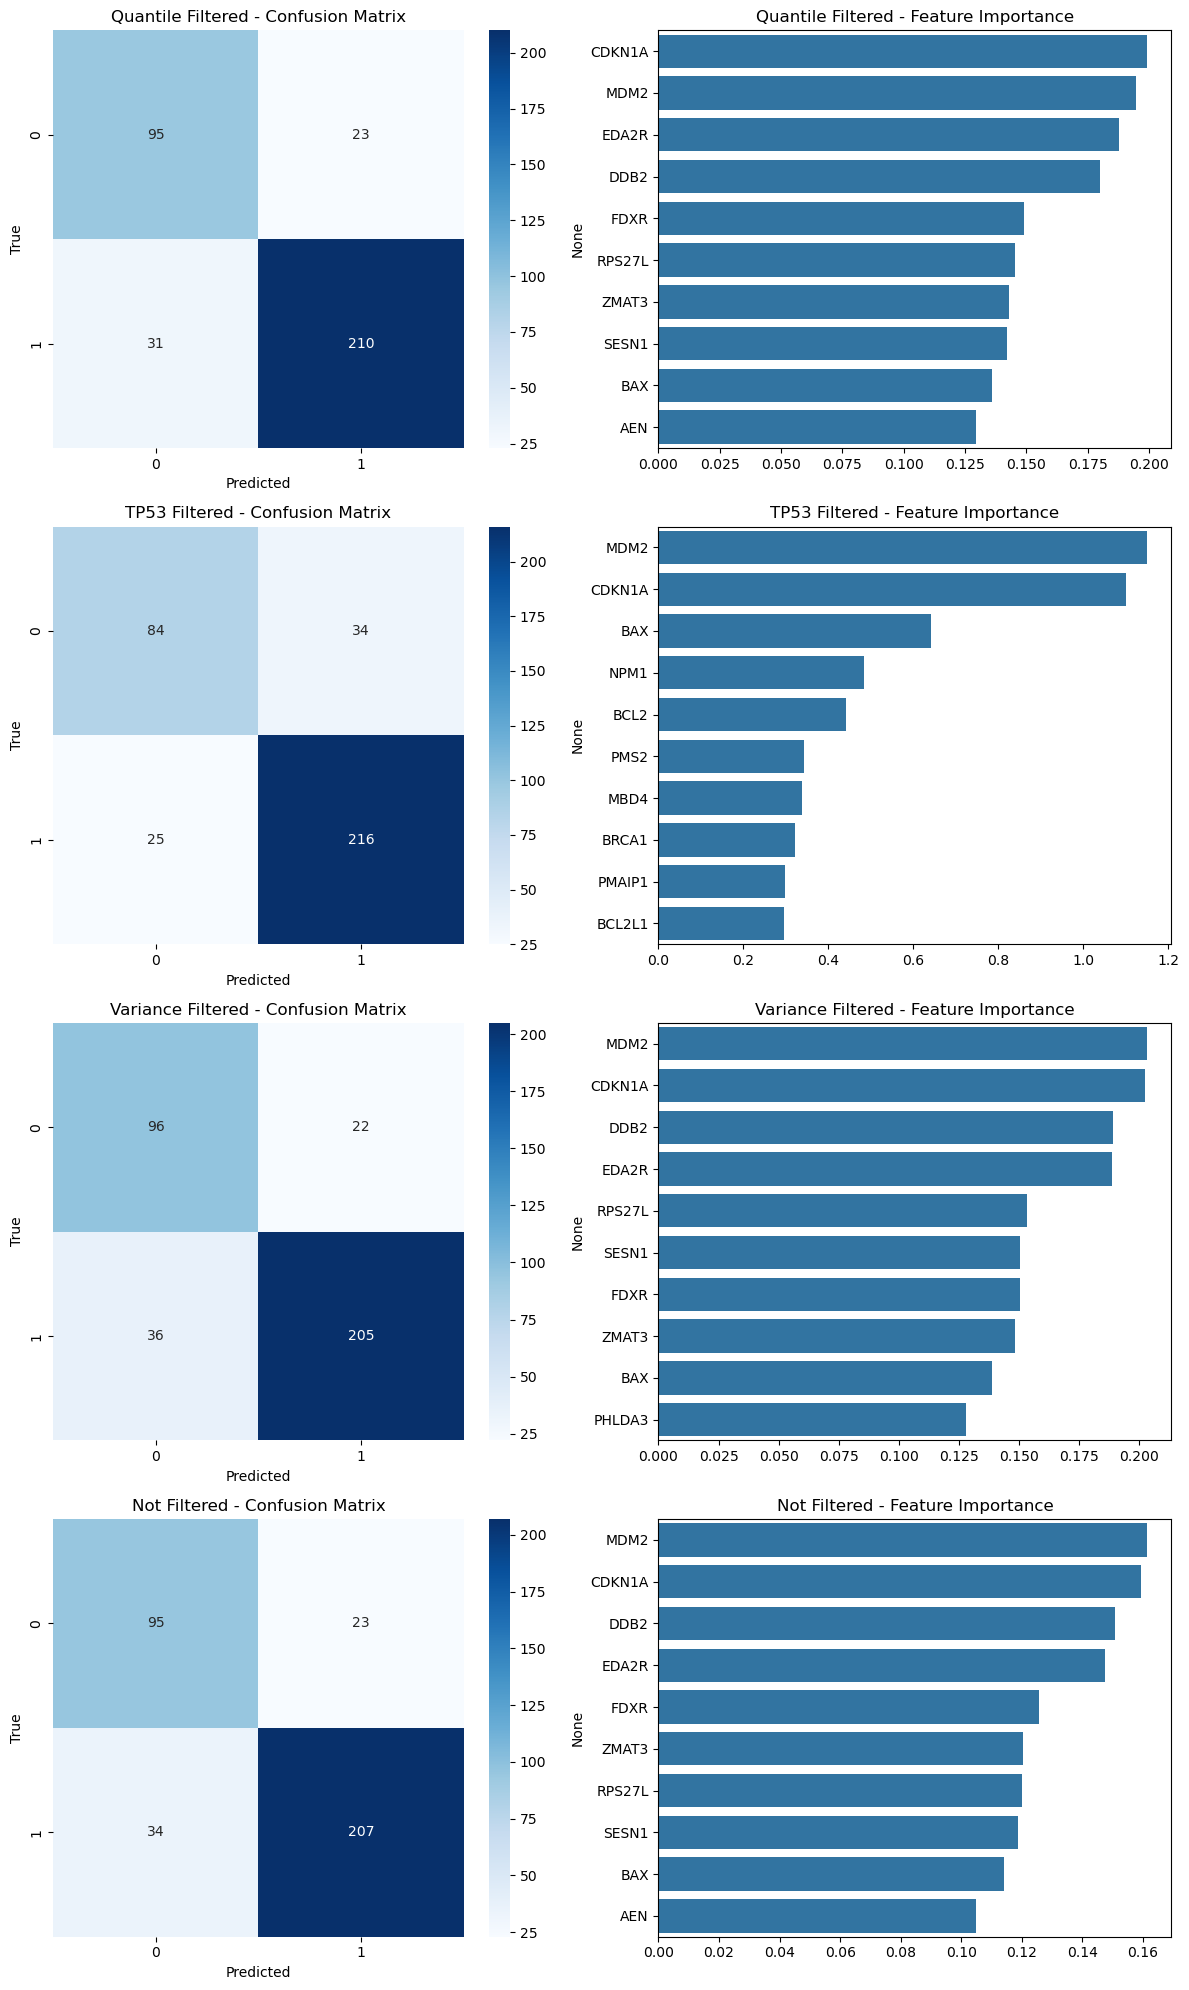

In [6]:
DATASET_NAMES = [
    "Quantile Filtered",
    "TP53 Filtered",
    "Variance Filtered",
    "Not Filtered"
]

train_and_evaluate_on_datasets(datasets, 'logistic', dataset_names=DATASET_NAMES)

## Support Vector Machine (SVM)

Quantile Filtered - Accuracy: 0.8607 - F1 Score: 0.8598 - AUC: 0.9034 - Model: svm
TP53 Filtered - Accuracy: 0.8747 - F1 Score: 0.8726 - AUC: 0.8907 - Model: svm
Variance Filtered - Accuracy: 0.8747 - F1 Score: 0.8726 - AUC: 0.9114 - Model: svm
Not Filtered - Accuracy: 0.8635 - F1 Score: 0.8627 - AUC: 0.9038 - Model: svm


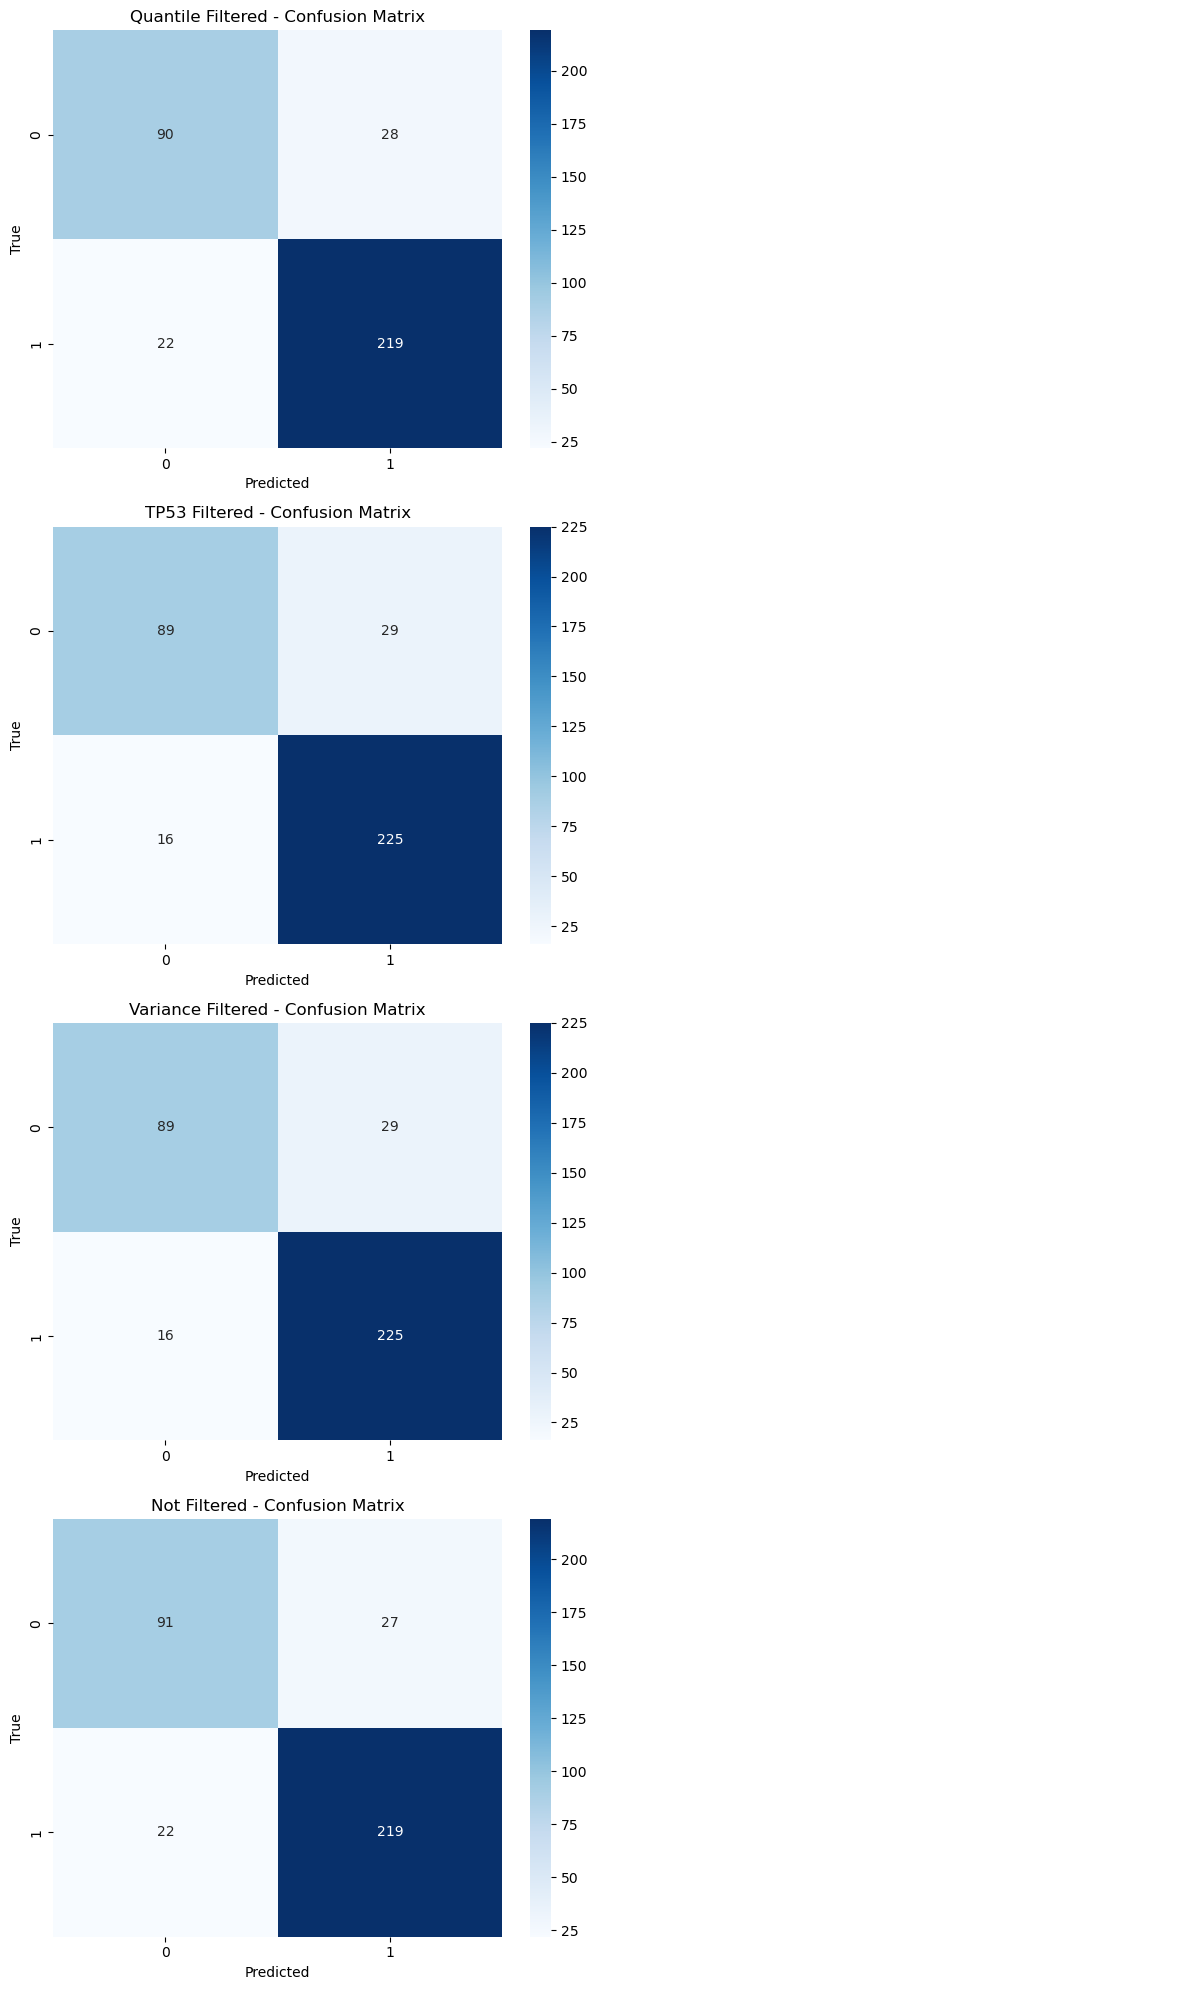

In [7]:
train_and_evaluate_on_datasets(datasets, 'svm', dataset_names=DATASET_NAMES)

## Random Forest

Quantile Filtered - Accuracy: 0.8635 - F1 Score: 0.8605 - AUC: 0.9041 - Model: random_forest
TP53 Filtered - Accuracy: 0.8663 - F1 Score: 0.8643 - AUC: 0.9061 - Model: random_forest
Variance Filtered - Accuracy: 0.8663 - F1 Score: 0.8647 - AUC: 0.9146 - Model: random_forest
Not Filtered - Accuracy: 0.8635 - F1 Score: 0.8609 - AUC: 0.9101 - Model: random_forest


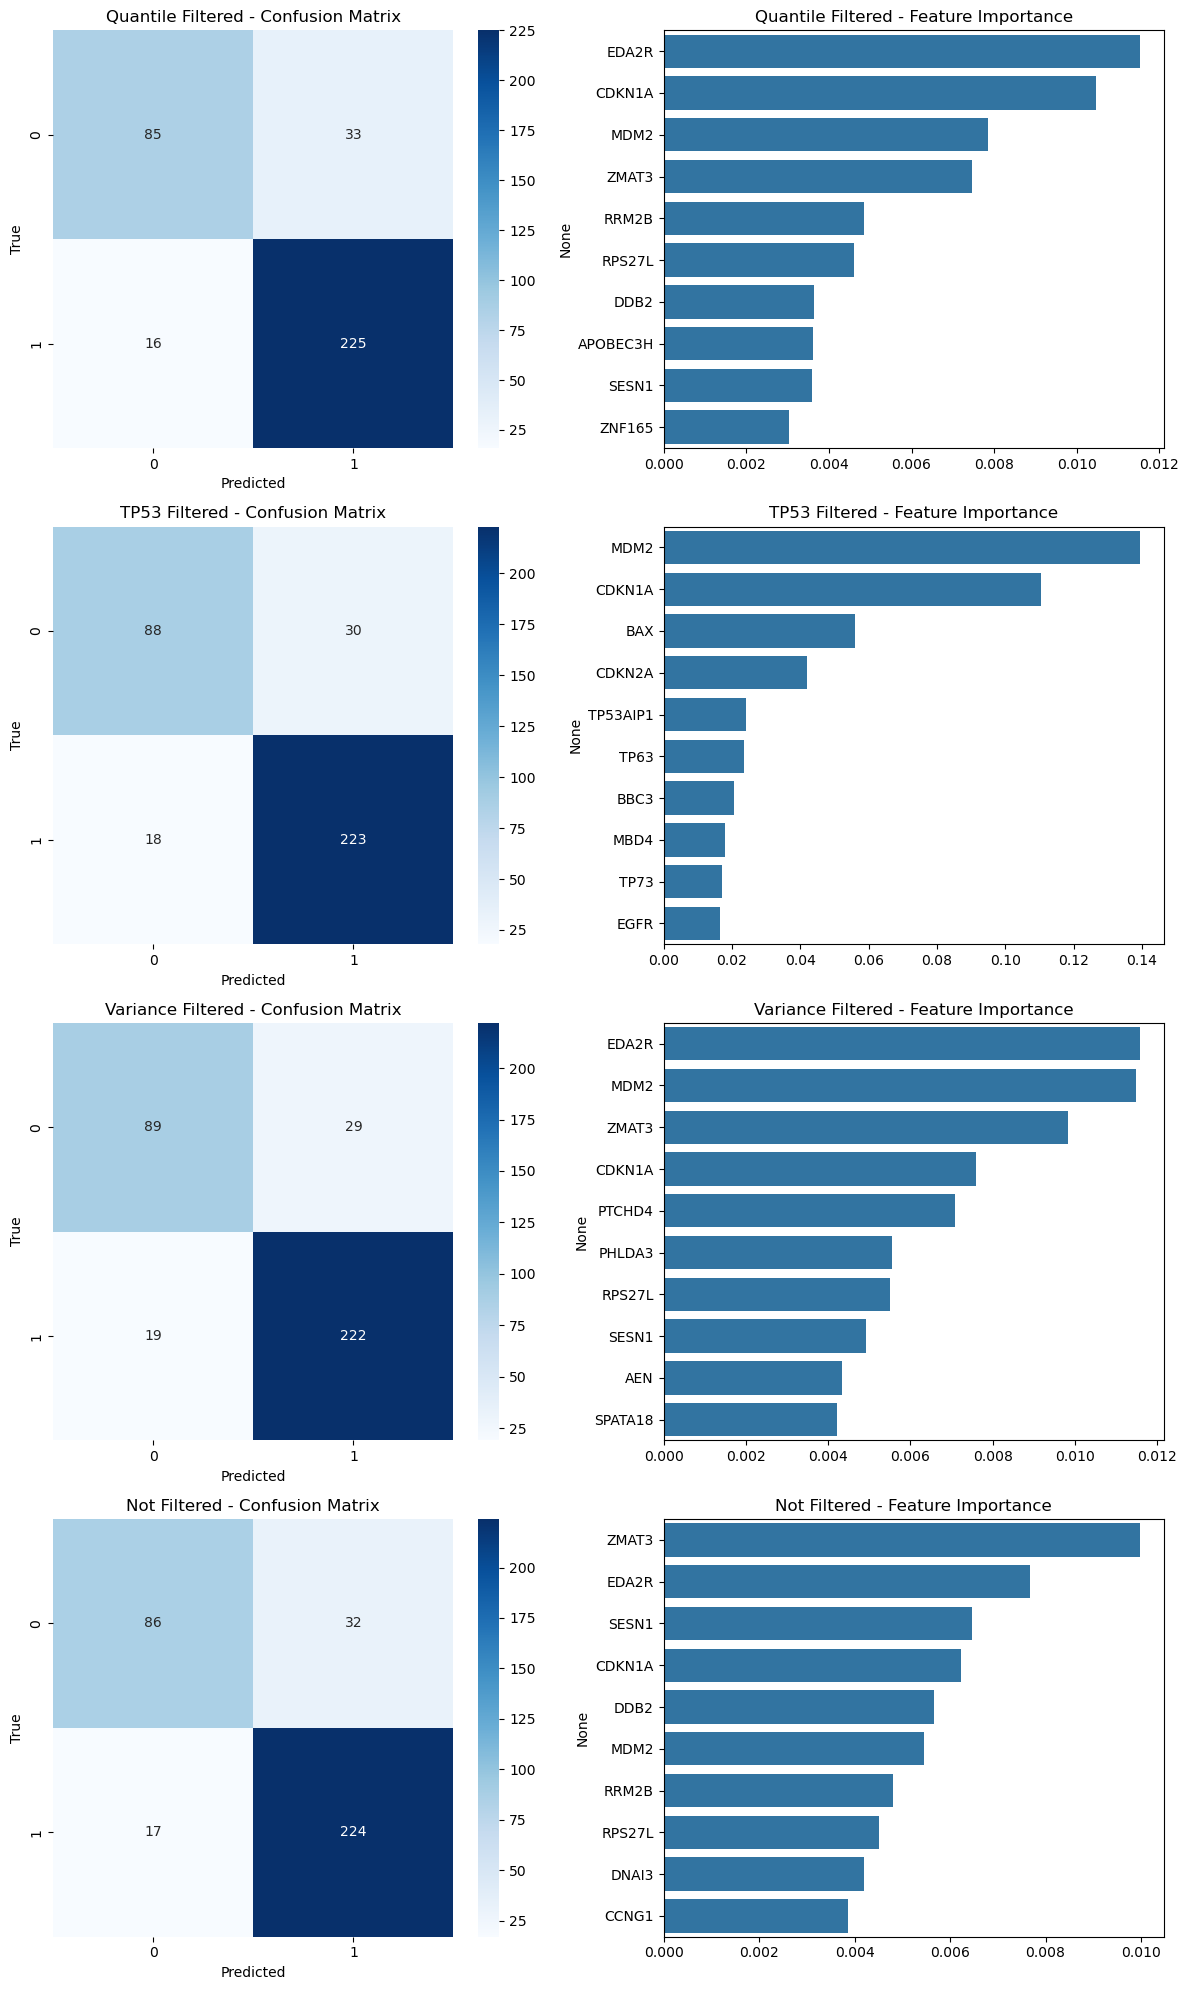

In [8]:
train_and_evaluate_on_datasets(datasets, 'random_forest', dataset_names=DATASET_NAMES)

## XGBoost

Quantile Filtered - Accuracy: 0.8691 - F1 Score: 0.8673 - AUC: 0.9319 - Model: xgboost
TP53 Filtered - Accuracy: 0.8747 - F1 Score: 0.8736 - AUC: 0.8998 - Model: xgboost
Variance Filtered - Accuracy: 0.8858 - F1 Score: 0.8843 - AUC: 0.9304 - Model: xgboost
Not Filtered - Accuracy: 0.8774 - F1 Score: 0.8760 - AUC: 0.9317 - Model: xgboost


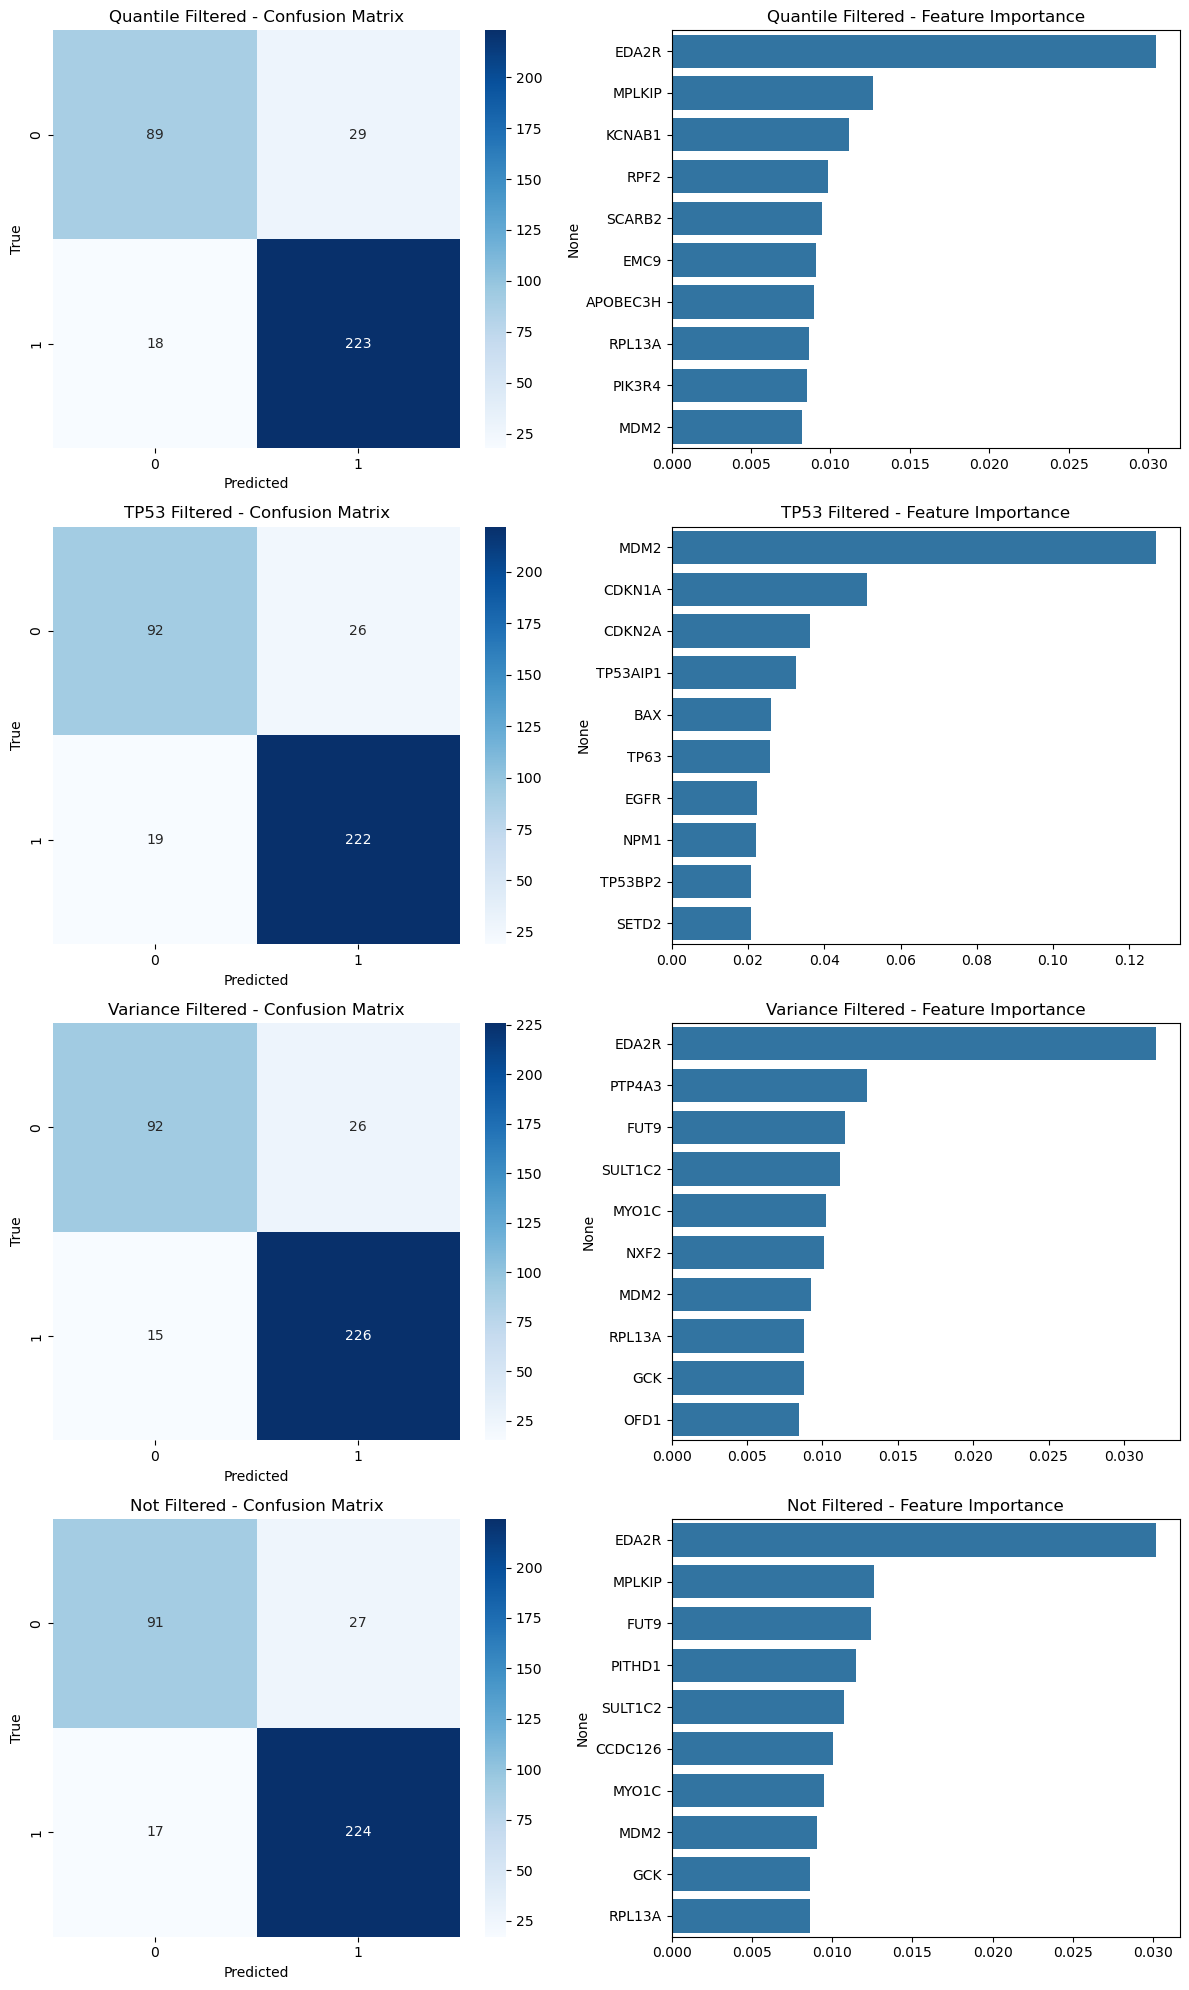

In [9]:
train_and_evaluate_on_datasets(datasets, 'xgboost', dataset_names=DATASET_NAMES)

## Model Performance Summary Table

| Model              | Quantile Filtered            | TP53 Filtered                | Variance Filtered                  | Not Filtered                      |
|--------------------|:----------------------------:|:----------------------------:|:----------------------------------:|:---------------------------------:|
| Logistic           | <u>0.8496 / 0.8508 / 0.8986</u> | 0.8357 / 0.8339 / 0.8812     | **0.8384 / 0.8405 / 0.9003**       | 0.8412 / 0.8429 / 0.8980          |
| SVM                | 0.8607 / 0.8598 / 0.9034     | 0.8747 / 0.8726 / 0.8907     | **0.8747 / 0.8726 / 0.9114**       | <u>0.8635 / 0.8627 / 0.9038</u>    |
| Random Forest      | 0.8635 / 0.8605 / 0.9041     | 0.8663 / 0.8643 / 0.9061     | **0.8663 / 0.8647 / 0.9146**       | <u>0.8635 / 0.8609 / 0.9101</u>    |
| XGBoost            | **0.8691 / 0.8673 / 0.9319** | 0.8747 / 0.8736 / 0.8998     | 0.8858 / 0.8843 / 0.9304           | <u>0.8774 / 0.8760 / 0.9317</u>    |

*Values are reported as Accuracy / F1 Score / AUC.  
**Bold** indicates the best AUC per model; <u>underline</u> indicates the second-best AUC per model.*  

### Summary & Next Step  
Across four algorithms (logistic, SVM, random-forest, XGBoost) the 61-gene **TP53 panel delivered virtually the same accuracy, F1, and AUC as models trained on 14-19 k features**. That tells us two things: (1) the biologically curated TP53 genes already capture most of the signal, and (2) the smaller footprint should generalise better and run faster. To see whether a tiny boost is still on the table, we’ll now **add the top four non-TP53 genes identified by XGBoost’s feature-importance ranking to the TP53 set (→ 65 genes)**, retrain all four models, and compare the deltas against the original TP53 baseline. If those extra markers help, we get maximum performance with minimal feature creep; if not, we keep the lean 61-gene panel and move on.

In [10]:
# Compare TP53 (dataset 2) and merged (dataset 4) using the same pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

# Helper function to run the pipeline for a given dataset and feature set

def run_tp53_vs_merged(X_train, X_test, y_train, y_test, feature_names, tp53_features, baseline, label):
    # 1. Get top-4 non-TP53 features from XGBoost
    xgb_full = XGBClassifier(random_state=42, n_jobs=-1)
    xgb_full.fit(X_train, y_train)
    imp_series = pd.Series(xgb_full.feature_importances_, index=feature_names)
    top4 = (
        imp_series.drop(labels=[g for g in tp53_features if g in imp_series.index])
        .nlargest(10)
        .index
        .tolist()
    )
    print(f"\nTop-10 genes added for {label}: {top4}")
    # 2. Build merged feature matrix (TP53 + top-4)
    merged_feats = tp53_features + top4
    X_train_sel = pd.DataFrame(X_train, columns=feature_names)[merged_feats]
    X_test_sel = pd.DataFrame(X_test, columns=feature_names)[merged_feats]
    # 3. Define models
    models = {
        "logistic": LogisticRegression(max_iter=2000, solver="lbfgs"),
        "svm":      SVC(kernel="rbf", probability=True, gamma="scale"),
        "random_forest": RandomForestClassifier(
            n_estimators=600, max_depth=None, random_state=42, n_jobs=-1
        ),
        "xgboost": XGBClassifier(
            n_estimators=800,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ),
    }
    # 4. Train/eval
    rows = []
    for name, model in models.items():
        if name in ("logistic", "svm"):
            clf = make_pipeline(StandardScaler(), model)
        else:
            clf = model
        clf.fit(X_train_sel, y_train)
        y_pred  = clf.predict(X_test_sel)
        y_proba = clf.predict_proba(X_test_sel)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test_sel)
        acc = accuracy_score(y_test, y_pred)
        f1  = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        b_acc, b_f1, b_auc = baseline[name]
        rows.append({
            "Model": name,
            "Accuracy": round(acc, 4),
            "ΔAccuracy": round(acc - b_acc, 4),
            "F1": round(f1, 4),
            "ΔF1": round(f1 - b_f1, 4),
            "AUC": round(auc, 4),
            "ΔAUC": round(auc - b_auc, 4),
        })
    delta_df = pd.DataFrame(rows)
    print(f"\n=== Δ-Performance vs original TP53 ({label}) ===")
    print(delta_df.to_string(index=False))

# Baseline metrics for TP53 (dataset 2)
baseline_tp53 = {
    "logistic":      (0.8357, 0.8339, 0.8812),
    "svm":           (0.8747, 0.8726, 0.8907),
    "random_forest": (0.8663, 0.8643, 0.9061),
    "xgboost":       (0.8747, 0.8736, 0.8998),
}

# TP53 dataset (dataset 2)
X_train2, X_test2, y_train2, y_test2, feature_names2 = datasets[1]
tp53_features2 = feature_names2.tolist()
run_tp53_vs_merged(X_train2, X_test2, y_train2, y_test2, feature_names2, tp53_features2, baseline_tp53, label="TP53 (61 genes)")

# Merged dataset (dataset 4)
X_train4, X_test4, y_train4, y_test4, feature_names4 = datasets[3]
tp53_features4 = feature_names2.tolist()  # Use TP53 features from dataset 2
run_tp53_vs_merged(X_train4, X_test4, y_train4, y_test4, feature_names4, tp53_features4, baseline_tp53, label="Merged (65 genes)")



Top-10 genes added for TP53 (61 genes): []

=== Δ-Performance vs original TP53 (TP53 (61 genes)) ===
        Model  Accuracy  ΔAccuracy     F1    ΔF1    AUC    ΔAUC
     logistic    0.8357    -0.0000 0.8798 0.0459 0.8812  0.0000
          svm    0.8747    -0.0000 0.9091 0.0365 0.8907 -0.0000
random_forest    0.8691     0.0028 0.9051 0.0408 0.9135  0.0074
      xgboost    0.8691    -0.0056 0.9039 0.0303 0.8938 -0.0060

Top-10 genes added for Merged (65 genes): ['EDA2R', 'MPLKIP', 'FUT9', 'PITHD1', 'SULT1C2', 'CCDC126', 'MYO1C', 'GCK', 'RPL13A', 'KCNMB4']

=== Δ-Performance vs original TP53 (Merged (65 genes)) ===
        Model  Accuracy  ΔAccuracy     F1    ΔF1    AUC   ΔAUC
     logistic    0.8384     0.0027 0.8782 0.0443 0.8870 0.0058
          svm    0.8747    -0.0000 0.9076 0.0350 0.8924 0.0017
random_forest    0.8802     0.0139 0.9128 0.0485 0.9153 0.0092
      xgboost    0.8802     0.0055 0.9121 0.0385 0.9015 0.0017


### “TP53 + Top-XGB” Results  

Adding XGBoost’s ten most informative **non-TP53** genes to the 61-gene TP53 panel (→ 65 genes) **never hurt accuracy or AUC and sharply lifted F1 across all models**.  
Random-Forest gained the most (≈ +1.4 pp accuracy, +4.9 pp F1, +0.9 pp AUC), while Logistic and XGBoost picked up smaller but still useful bumps; SVM held its accuracy but improved its class-balance (F1 + 3.5 pp). The merged 65-gene set therefore matches or beats every larger feature matrix with only a tiny footprint increase.

| Model | ΔAccuracy | ΔF1 | ΔAUC |
|-------|:---------:|:---:|:----:|
| Logistic        | +0.0027 | <u>+0.0443</u> | <u>+0.0058</u> |
| SVM             | +0.0000 | +0.0350 | +0.0017 |
| **Random Forest** | **+0.0139** | **+0.0485** | **+0.0092** |
| XGBoost         | <u>+0.0055</u> | +0.0385 | +0.0017 |

*Bold = largest gain per metric; underline = second-largest.*  

The take-away: **a biologically curated core (TP53) plus a sprinkling of data-driven markers gives you the best of both worlds—compact, interpretable, and top-performing.**  
Next, we can (i) cross-validate the 65-gene panel to confirm generalisation, and (ii) test even smaller “TP53 + top-k” subsets (k = 3–5) to see how far we can compress without sacrificing the uplift.  

### Why a few of the added genes matter  
* **EDA2R** – a direct p53-responsive TNF-receptor gene; if p53 is functional you expect higher EDA2R, so its strong signal alongside TP53 status is no surprise.  
* **MPLKIP** – partners with PLK1 in the G2/M checkpoint; PLK1 activity shoots up when p53 is lost, so MPLKIP tagging that shift is logical.  

Bottom line: the XGBoost screen isn’t pulling random noise – at least some of the extra markers slot neatly into known p53-controlled cell-cycle and apoptosis wiring, which explains the performance bump.